<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

In [148]:
past = pd.read_csv('../dat/past.csv.gz')
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [3]:
past.head()

product_id       user_id  NumOfEventsInJourney  NumSessions  \
0     5866936  5.618978e+08              1.333333     1.333333   
1     5647110  5.326529e+08              2.250000     1.500000   
2     5790472  4.578109e+08              1.000000     1.000000   
3     5811598  4.612641e+08              1.500000     1.500000   
4     5846363  5.157993e+08              1.875000     1.375000   

   interactionTime  maxPrice  minPrice  NumCart   NumView  NumRemove  ...  \
0         5550.000  15.84000  15.84000     0.00  1.333333       0.00  ...   
1        27556.500   5.80000   5.56500     1.25  0.250000       0.25  ...   
2            0.000   6.27250   6.27250     0.25  0.750000       0.00  ...   
3       131532.500   5.56000   5.56000     0.25  1.000000       0.25  ...   
4        11055.875   4.08625   4.08625     0.50  1.000000       0.25  ...   

    Dec  Afternoon  Dawn  EarlyMorning   Evening  Morning  Night  Purchased?  \
0  0.00      0.000   0.0      0.666667  0.333333     0.00   0.00           0   
1  0.25      0.750   0.0      0.000000  0.250000     0.00   0.00           0   
2  0.00      0.000   0.0      0.000000  0.750000     0.25   0.00           0   
3  0.25      0.000   0.0      0.000000  0.500000     0.00   0.25           0   
4  0.25      0.375   0.0      0.125000  0.250000     0.25   0.00           1   

   Noon  Category  
0  0.00       1.0  
1  0.00       1.0  
2  0.00       1.0  
3  0.25       1.0  
4  0.00       1.0  

[5 rows x 37 columns]

In [4]:
past.shape

(5000, 37)

In [5]:
past['Purchased?'].value_counts()/past.__len__()

#past[past['Purchased?'] == 1].__len__() / past.__len__()

0    0.6562
1    0.3438
Name: Purchased?, dtype: float64

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [6]:
X = past.drop(['product_id', 'user_id'], axis=1)
y = X.pop('Purchased?')

In [6]:
y

0       0
1       0
2       0
3       0
4       1
       ..
4995    0
4996    1
4997    0
4998    0
4999    0
Name: Purchased?, Length: 5000, dtype: int64

In [7]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(5000, 34)

In [9]:
X_normalized = pd.DataFrame(X_scaled, columns=X.columns)
X_normalized.head()

NumOfEventsInJourney  NumSessions  interactionTime  maxPrice  minPrice  \
0             -0.466366     0.008746        -0.351856  0.705469  0.708516   
1              0.225669     0.240810        -0.320053 -0.139505 -0.156742   
2             -0.718016    -0.455381        -0.359877 -0.099739 -0.097163   
3             -0.340542     0.240810        -0.169792 -0.159704 -0.157163   
4             -0.057436     0.066762        -0.343899 -0.283736 -0.281267   

    NumCart   NumView  NumRemove  InsessionCart  InsessionView  ...       Nov  \
0 -0.958711  0.522796  -0.535676      -0.325080      -0.268297  ... -0.735079   
1  1.252531 -0.765426  -0.211881      -0.272102      -0.245195  ...  0.147418   
2 -0.516462 -0.170862  -0.535676      -0.081378       0.267657  ...  0.147418   
3 -0.516462  0.126420  -0.211881      -0.279165      -0.092725  ...  0.147418   
4 -0.074214  0.126420  -0.211881      -0.256208      -0.224404  ...  0.147418   

        Dec  Afternoon      Dawn  EarlyMorning   Evening   Morning     Night  \
0 -0.664901  -0.774188 -0.381162      2.048532  0.308813 -0.670613 -0.447714   
1  0.313293   1.947849 -0.381162     -0.661216  0.020702 -0.670613 -0.447714   
2 -0.664901  -0.774188 -0.381162     -0.661216  1.749366  0.320204 -0.447714   
3  0.313293  -0.774188 -0.381162     -0.661216  0.885034 -0.670613  0.860628   
4  0.313293   0.586831 -0.381162     -0.153139  0.020702  0.320204 -0.447714   

       Noon  Category  
0 -0.385606 -0.328074  
1 -0.385606 -0.328074  
2 -0.385606 -0.328074  
3  1.238862 -0.328074  
4 -0.385606 -0.328074  

[5 rows x 34 columns]

In [10]:
#X_reduced = PCA(n_components=5).fit_transform(X_normalized)
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_normalized)

In [11]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [12]:
pca.explained_variance_ratio_
#explained_variance_ratio
# Print the explained variance ratio for each component
#for i, explained_variance in enumerate(explained_variance_ratio):
#    print("Component {}: {:.2f}%".format(i + 1, explained_variance * 100))

array([0.10282057, 0.09445702, 0.06513115, 0.0510884 , 0.0421157 ])

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [13]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [14]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

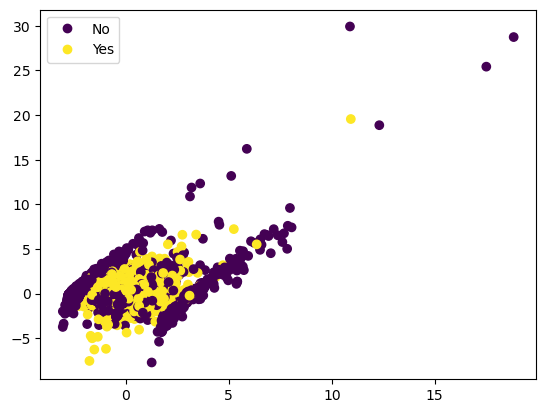

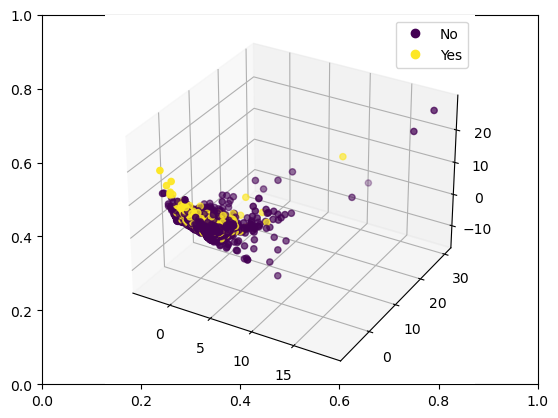

In [15]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [16]:
# YOUR CODE HERE (imports!)
from sklearn.model_selection import train_test_split

def train(X, y, standardize = True) -> None:
    """Train a model on the given data.
    
    Args:
        X (pd.DataFrame): The data to train on.
        y (pd.Series): The target variable.
        standardize (bool): Whether to standardize the data.
    """
    # YOUR CODE HERE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test
    

Now apply the pipeline on the all the features `X` and review the performance

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

def train2(X_reduced, y, standardize = True) -> None:
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=0)
    pipeline = Pipeline([
        ('clf', LogisticRegression())
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    pass

Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [18]:
train2(X_reduced, y)

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       649
           1       0.05      0.00      0.01       351

    accuracy                           0.63      1000
   macro avg       0.35      0.49      0.39      1000
weighted avg       0.43      0.63      0.50      1000



In [19]:
train2(X_reduced, y)

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       649
           1       0.05      0.00      0.01       351

    accuracy                           0.63      1000
   macro avg       0.35      0.49      0.39      1000
weighted avg       0.43      0.63      0.50      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [20]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [20]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(X)
        inertias.append(model.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

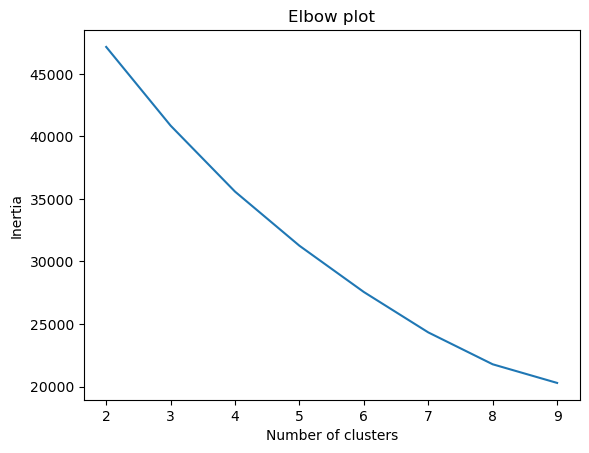

In [21]:
visualize_elbow(X_reduced, range(2, 10))

4. What are the disadvantage to use the Elbow method? 

    *YOUR ANSWER HERE*
    The elbow method has limitations such as; subectivity, limited to linear models, multiple elbows (in some cases difficult to determine the optimal number), not suitable for high-dimensional data.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [22]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.2515196453717698
For n_clusters = 3 The average silhouette_score is : 0.25975249474929774
For n_clusters = 4 The average silhouette_score is : 0.29679254252184967
For n_clusters = 5 The average silhouette_score is : 0.27885688951903187
For n_clusters = 6 The average silhouette_score is : 0.244722562216082
For n_clusters = 7 The average silhouette_score is : 0.2518872406453242
For n_clusters = 8 The average silhouette_score is : 0.2706782530890506
For n_clusters = 9 The average silhouette_score is : 0.2754020150737032
For n_clusters = 10 The average silhouette_score is : 0.26945289404164074


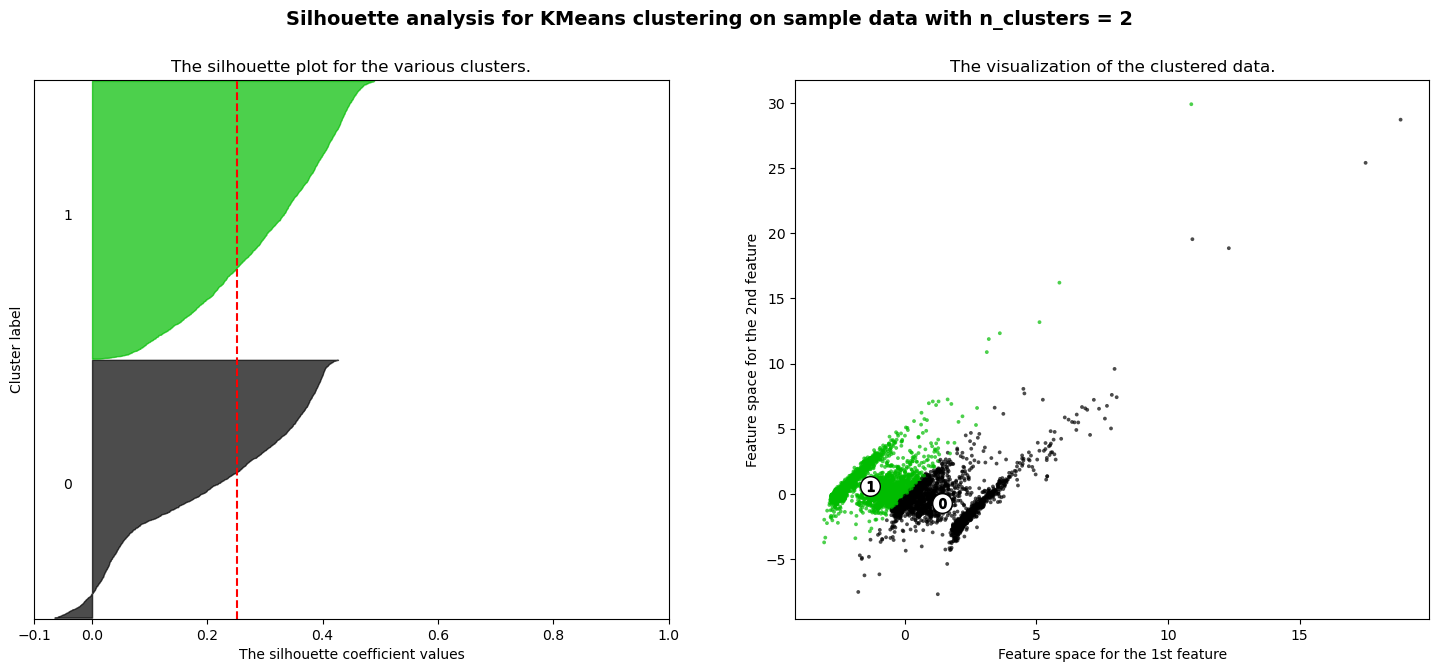

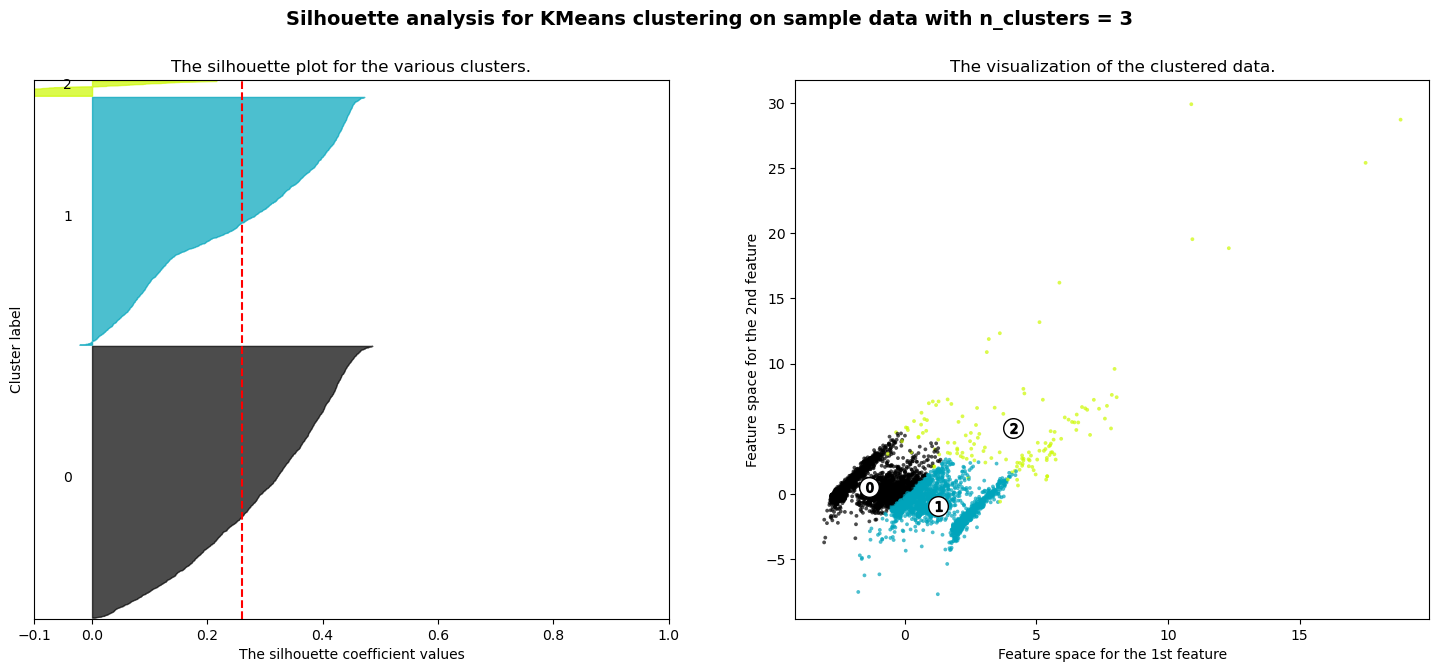

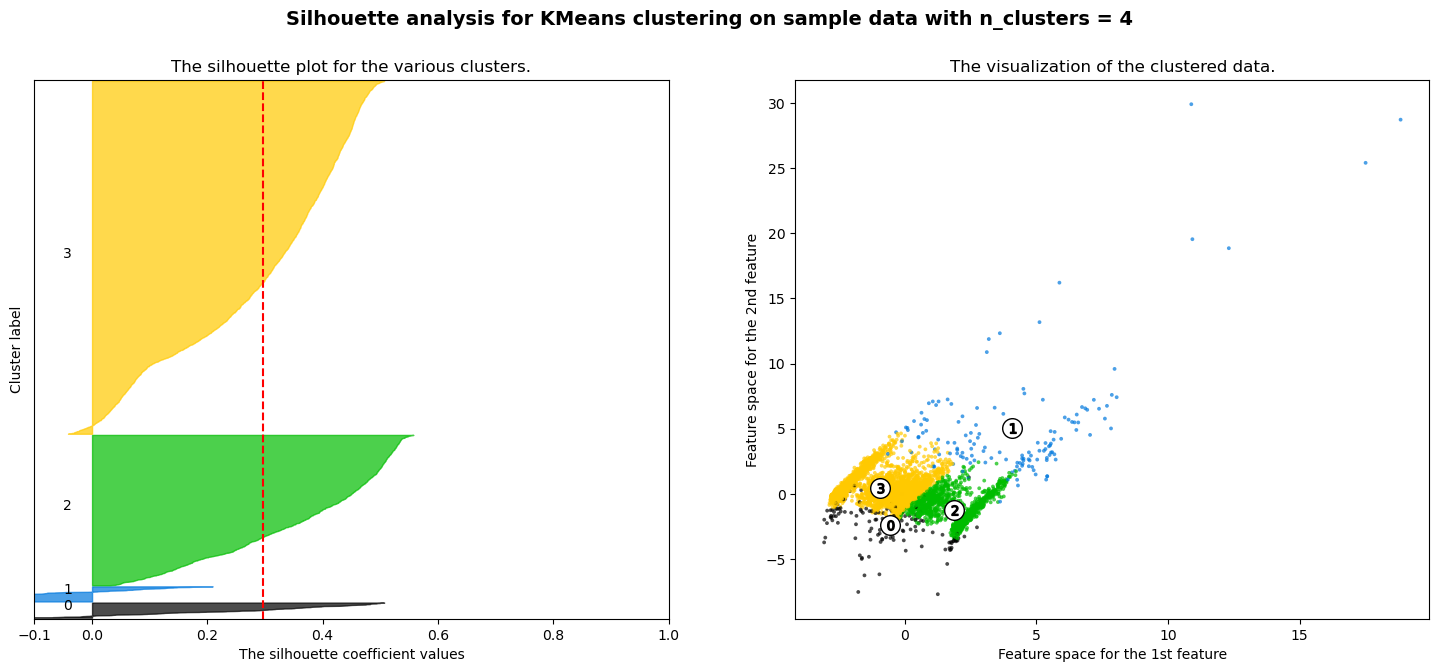

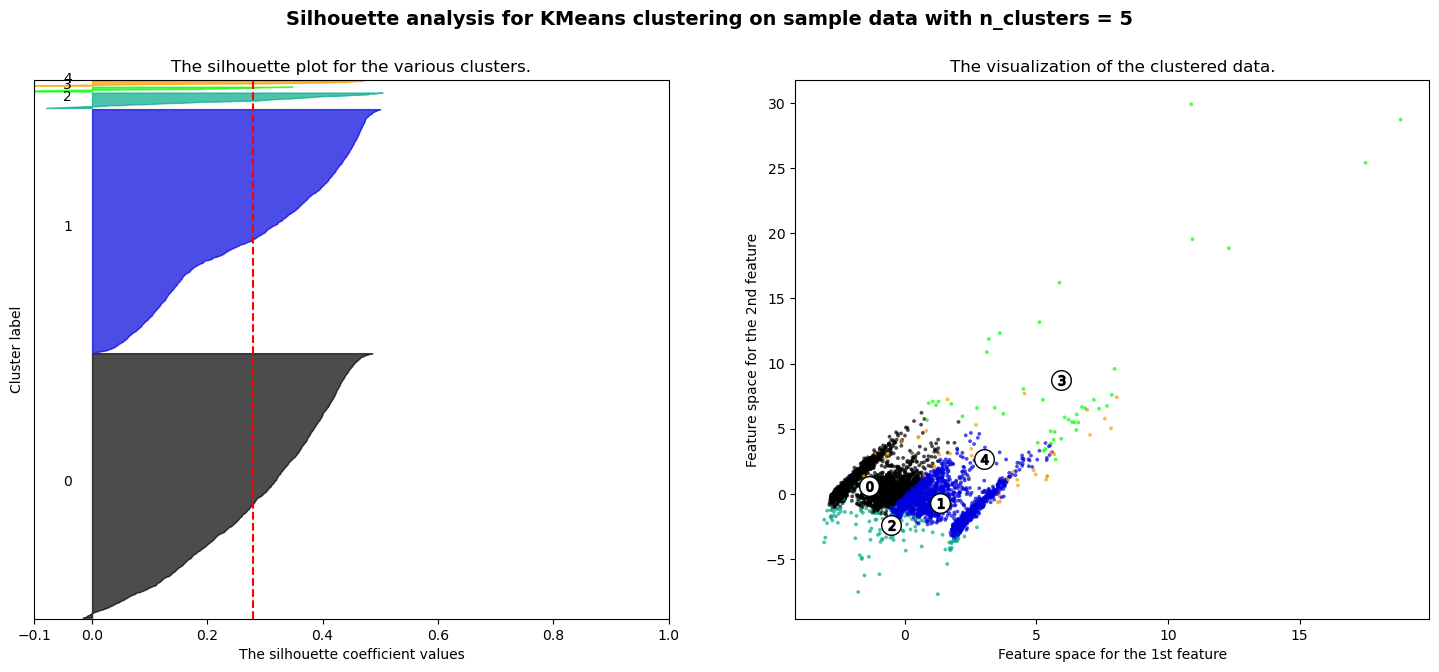

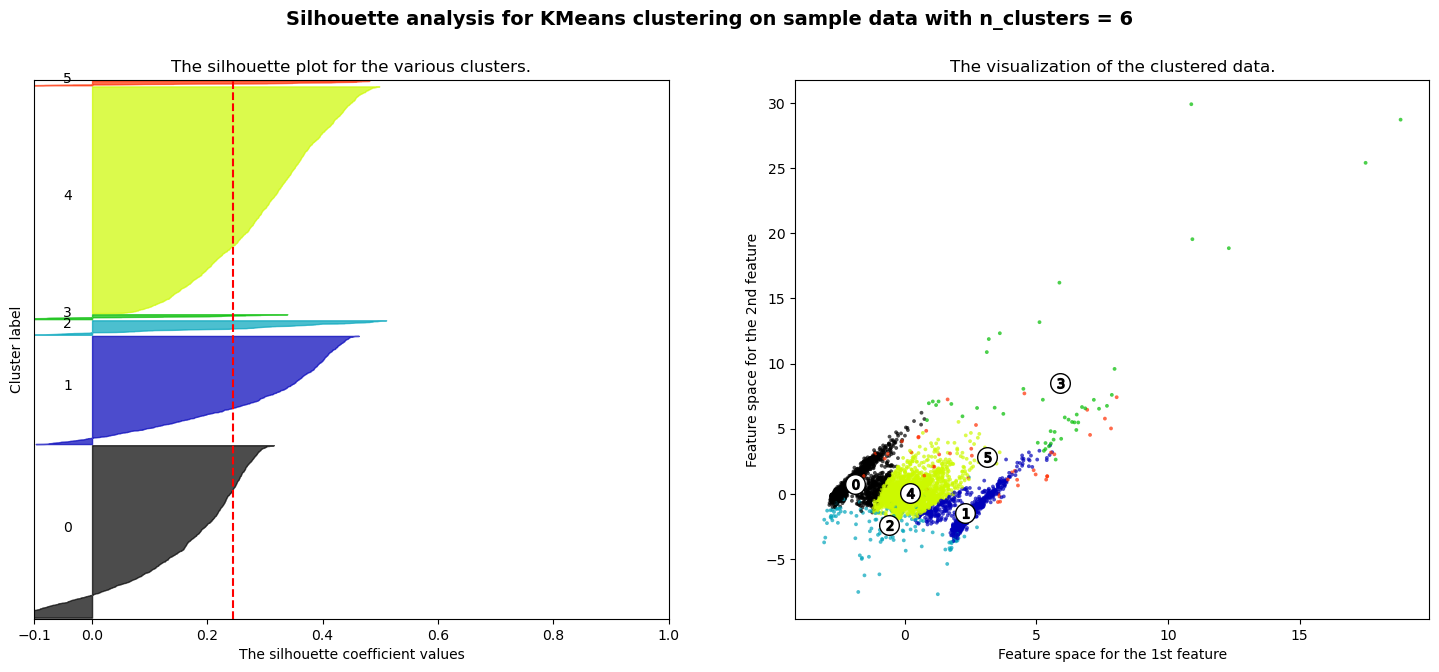

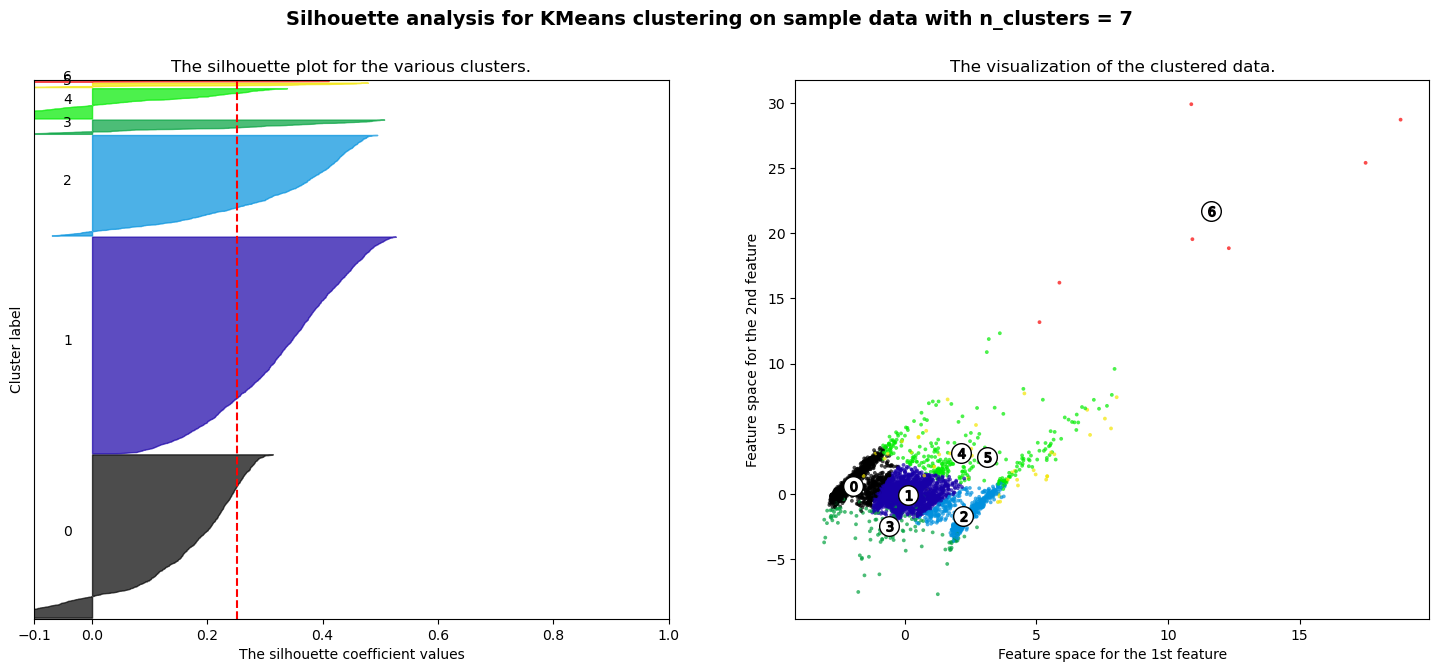

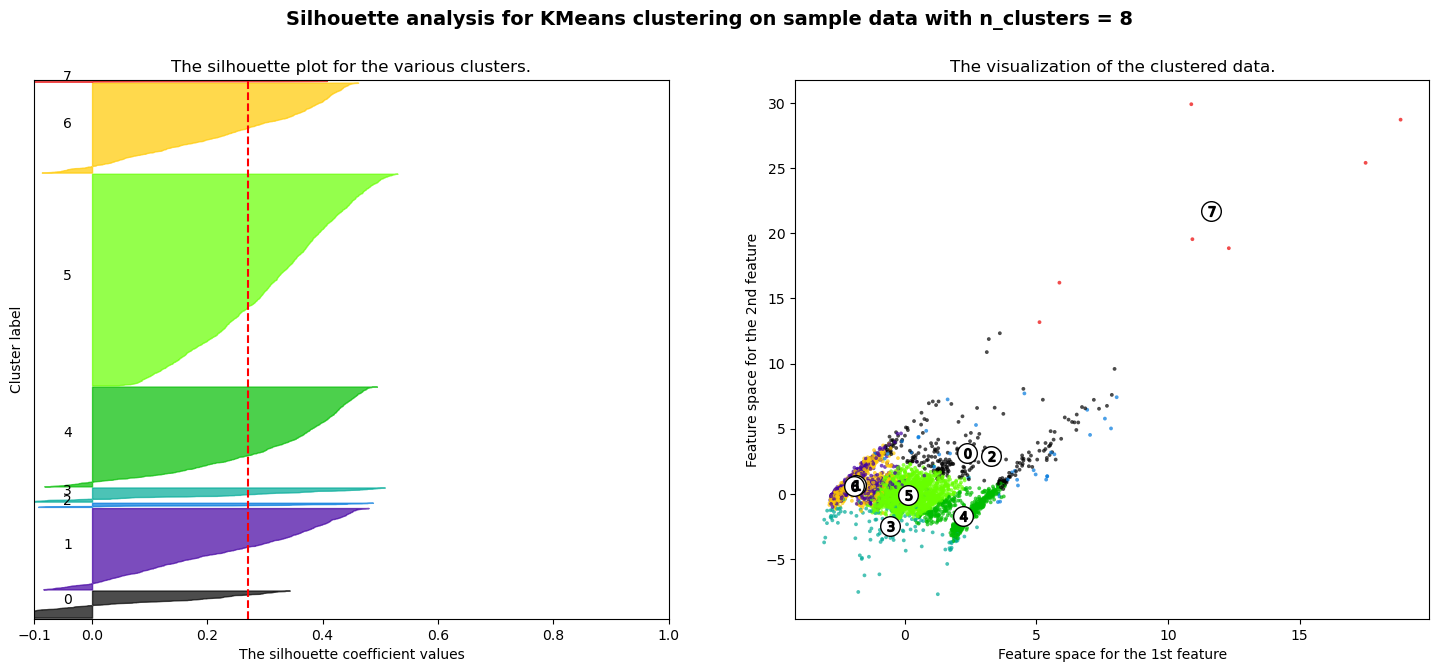

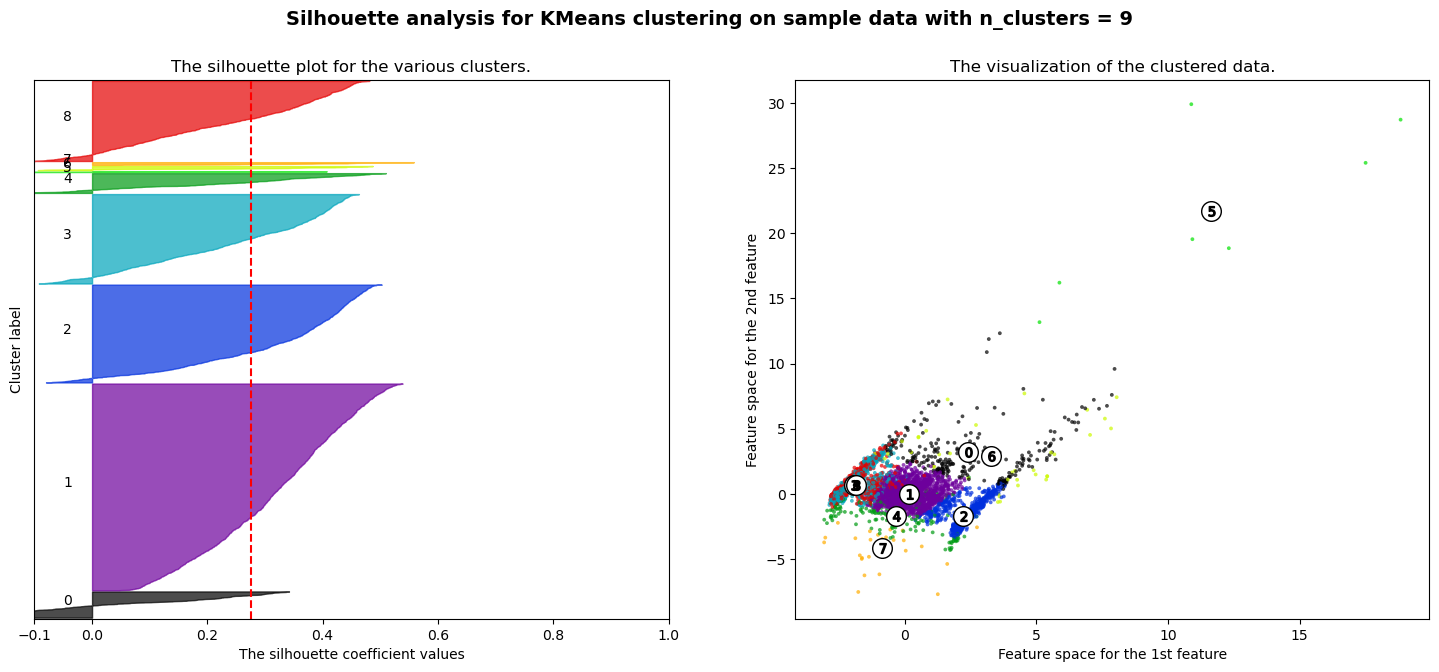

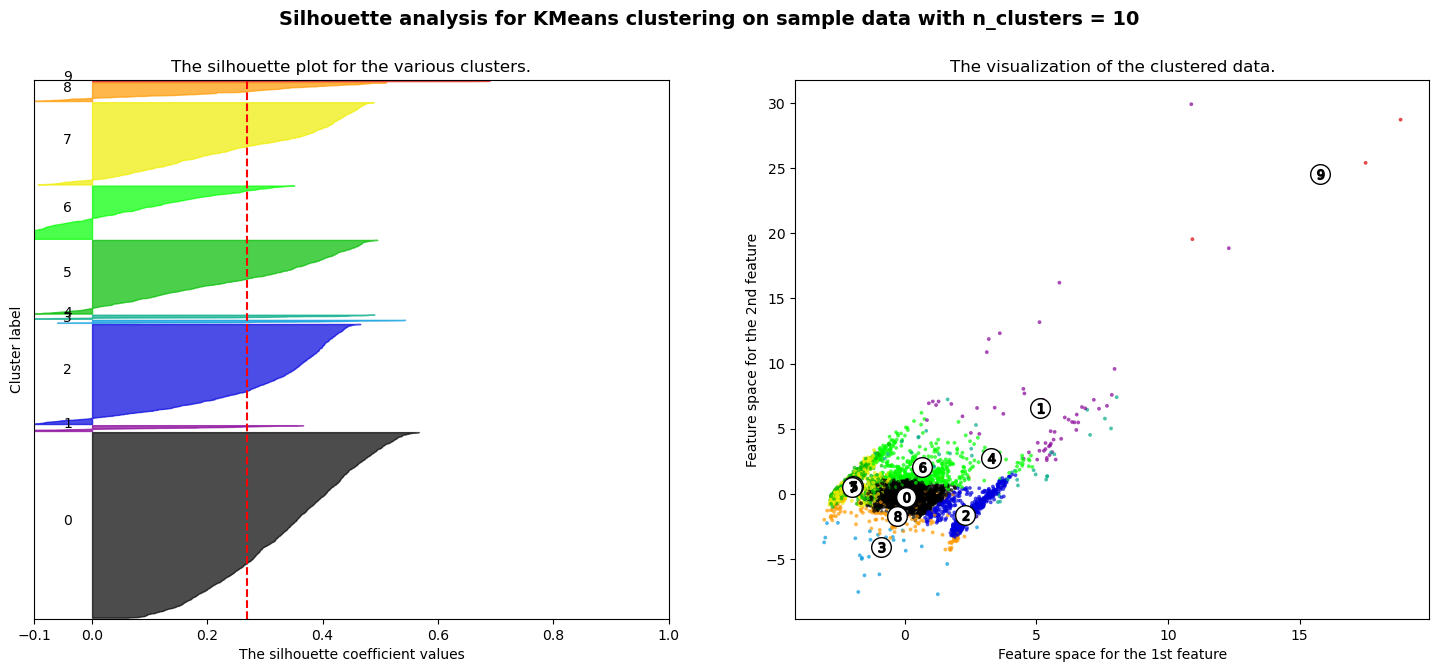

In [23]:
#def visualize_silhouette(max_clusters:int, X:np.ndarray, random_state:int=10) -> None:
visualize_silhouette(10, X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [24]:
km = 8
model = KMeans(n_clusters=km, random_state=10)

7. What is the size of each cluster? 

In [25]:
#model.__sizeof__()

model.fit(X_reduced)
labels = model.labels_

unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Cluster sizes:", cluster_sizes)

Cluster sizes: {0: 257, 1: 769, 2: 40, 3: 134, 4: 943, 5: 2000, 6: 850, 7: 7}


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [26]:
past['cluster_pca'] = model.predict(X_reduced)
#visualize_2pcs(X_reduced, labels)


In [27]:
past['cluster_pca'].value_counts()

5    2000
4     943
6     850
1     769
0     257
3     134
2      40
7       7
Name: cluster_pca, dtype: int64

9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

    *YOUR ANSWER HERE*

<AxesSubplot:xlabel='cluster_pca', ylabel='count'>

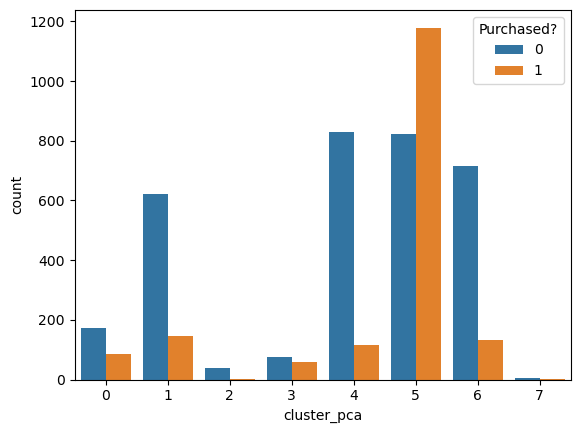

In [28]:
#past['cluster_pca'].value_counts().plot(kind='bar', title='Cluster Sizes')
#plt.scatter(x=past['cluster_pca'], y=past['Purchased?'])
import seaborn as sns
sns.countplot(x='cluster_pca', hue='Purchased?', data=past)

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*
    

In [29]:
# YOUR CODE HERE
from sklearn.cluster import AgglomerativeClustering
agglo_clustering = AgglomerativeClustering(n_clusters=8)
agglo_clustering.fit(X_reduced)
labels = agglo_clustering.labels_
past['cluster_agglo'] = labels


unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

print("Cluster sizes:", cluster_sizes)

Cluster sizes: {0: 307, 1: 127, 2: 79, 3: 894, 4: 2376, 5: 575, 6: 2, 7: 640}


For n_clusters = 2 The average silhouette_score is : 0.5838482470652194
For n_clusters = 3 The average silhouette_score is : 0.47432181020116004
For n_clusters = 4 The average silhouette_score is : 0.4387809111902581
For n_clusters = 5 The average silhouette_score is : 0.44907020163069583
For n_clusters = 6 The average silhouette_score is : 0.42995761308202335
For n_clusters = 7 The average silhouette_score is : 0.432297458015783
For n_clusters = 8 The average silhouette_score is : 0.4219255901795407
For n_clusters = 9 The average silhouette_score is : 0.4263753567617564
For n_clusters = 10 The average silhouette_score is : 0.413610375194476


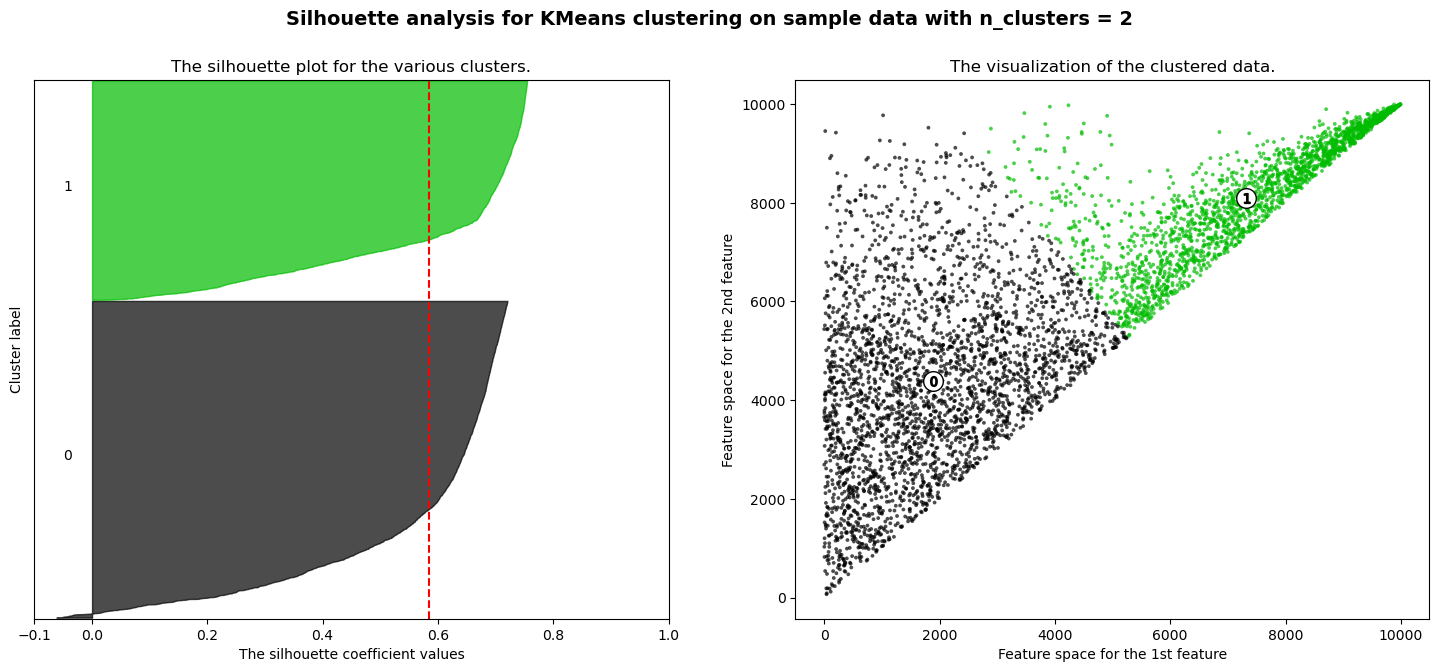

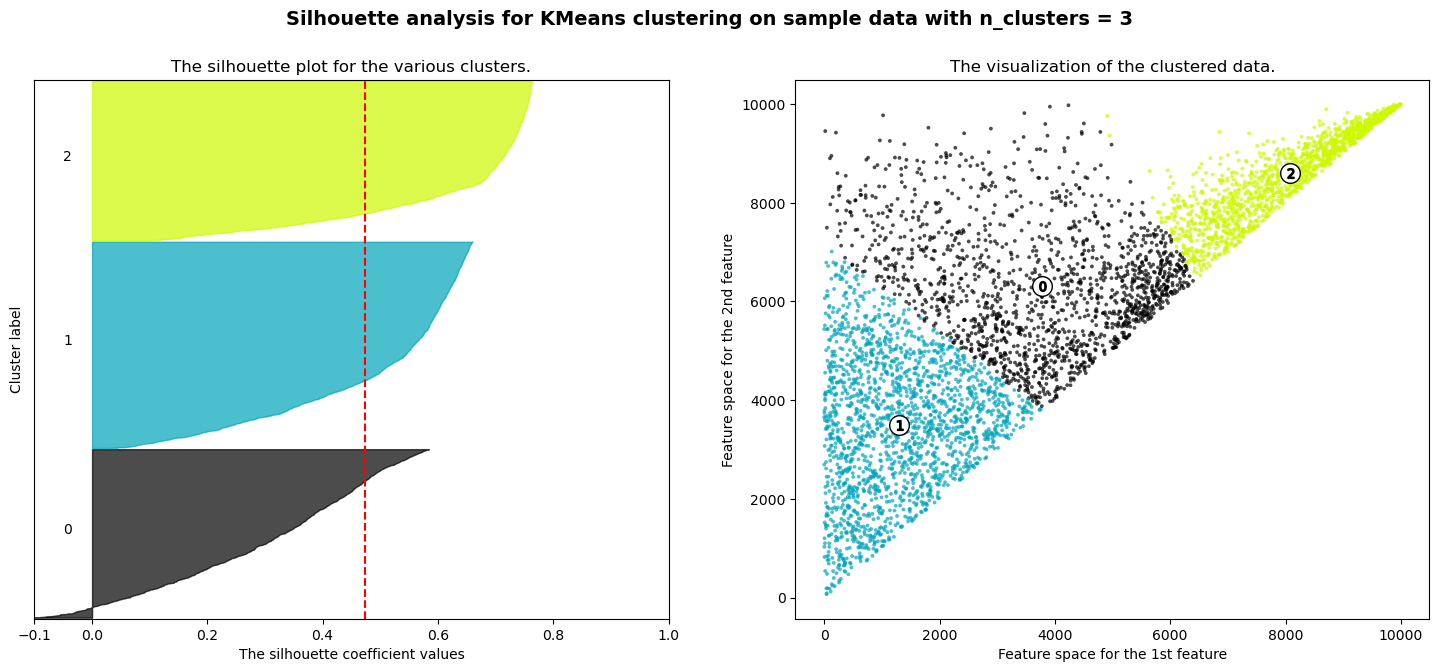

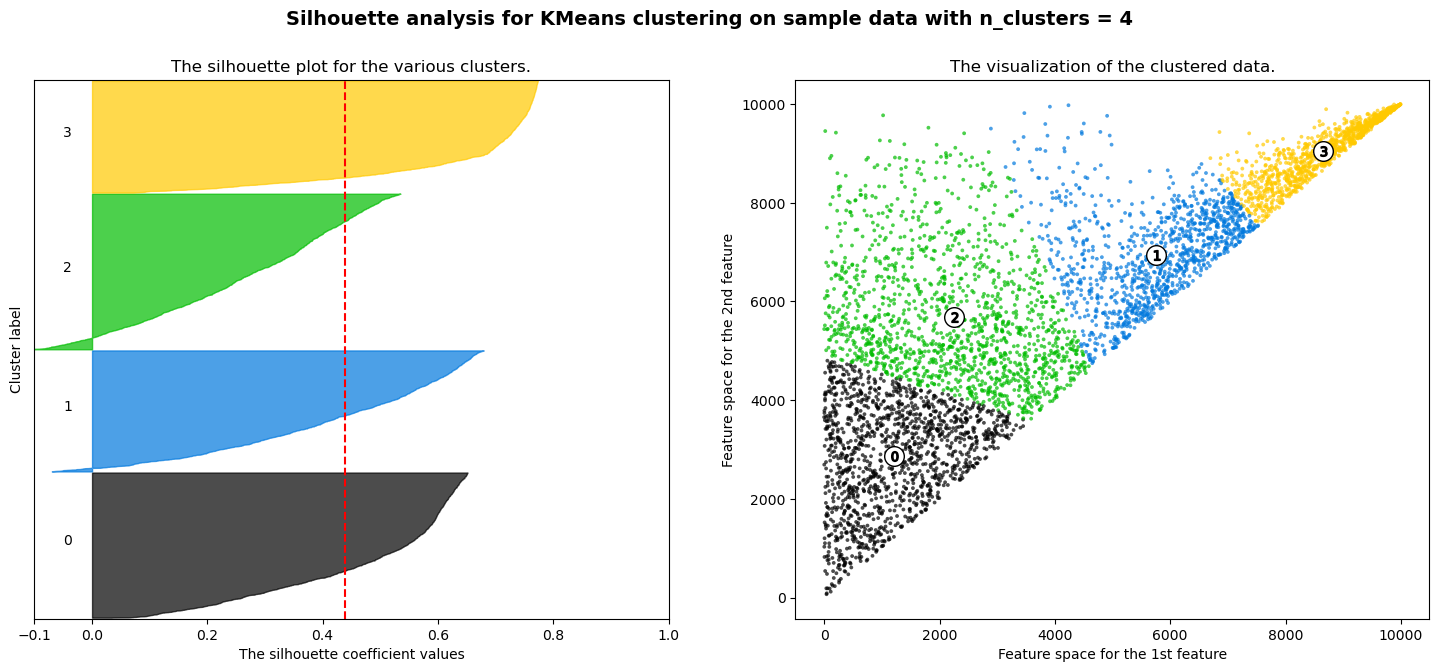

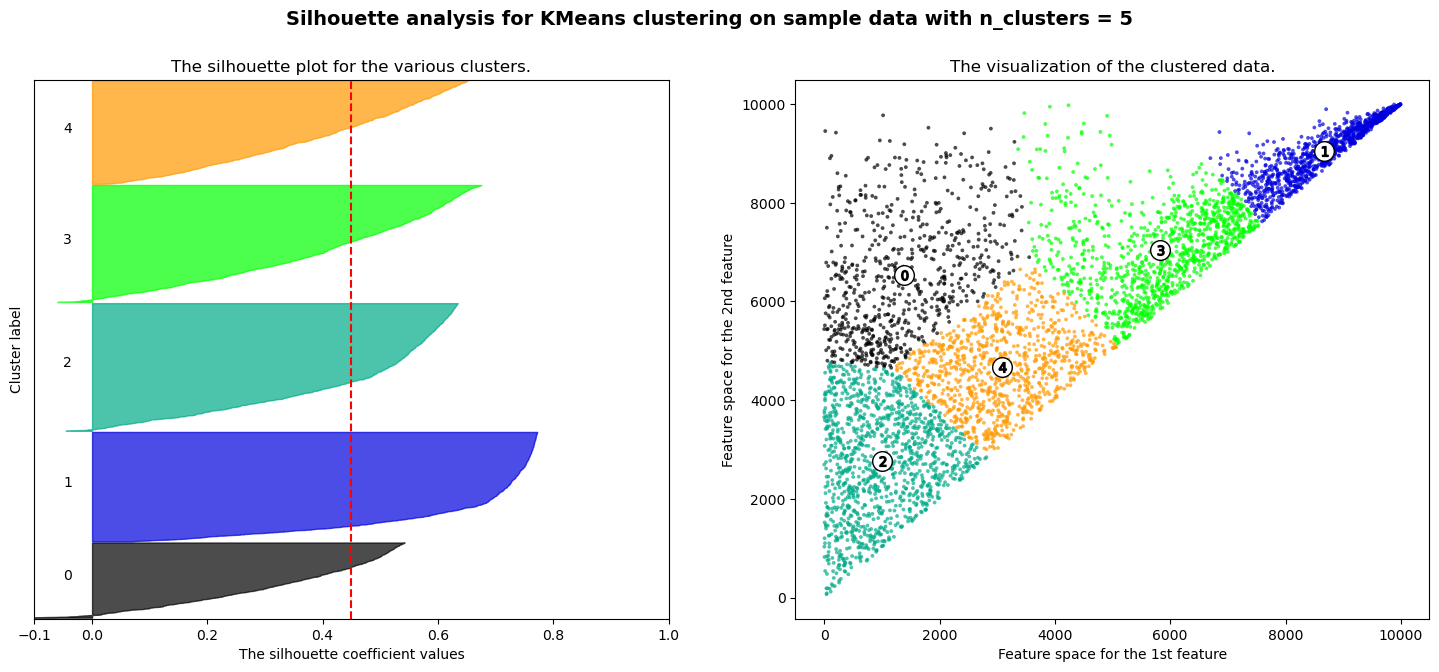

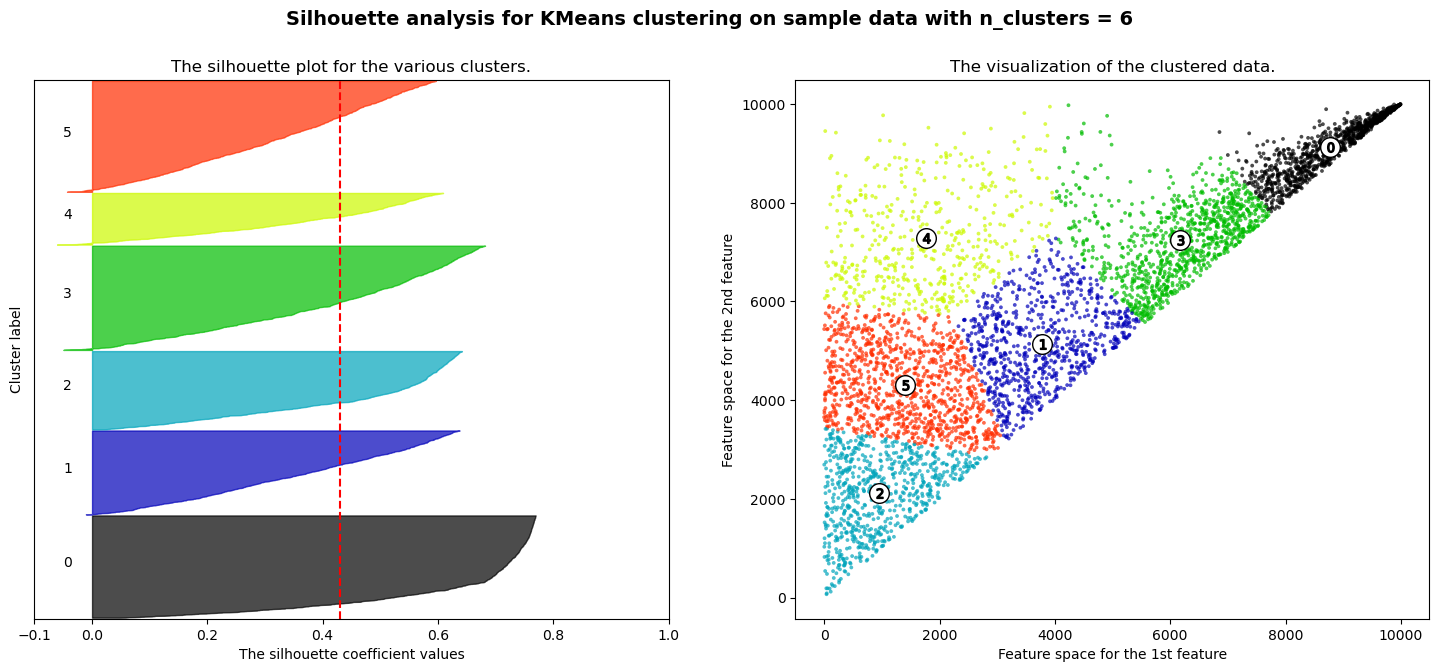

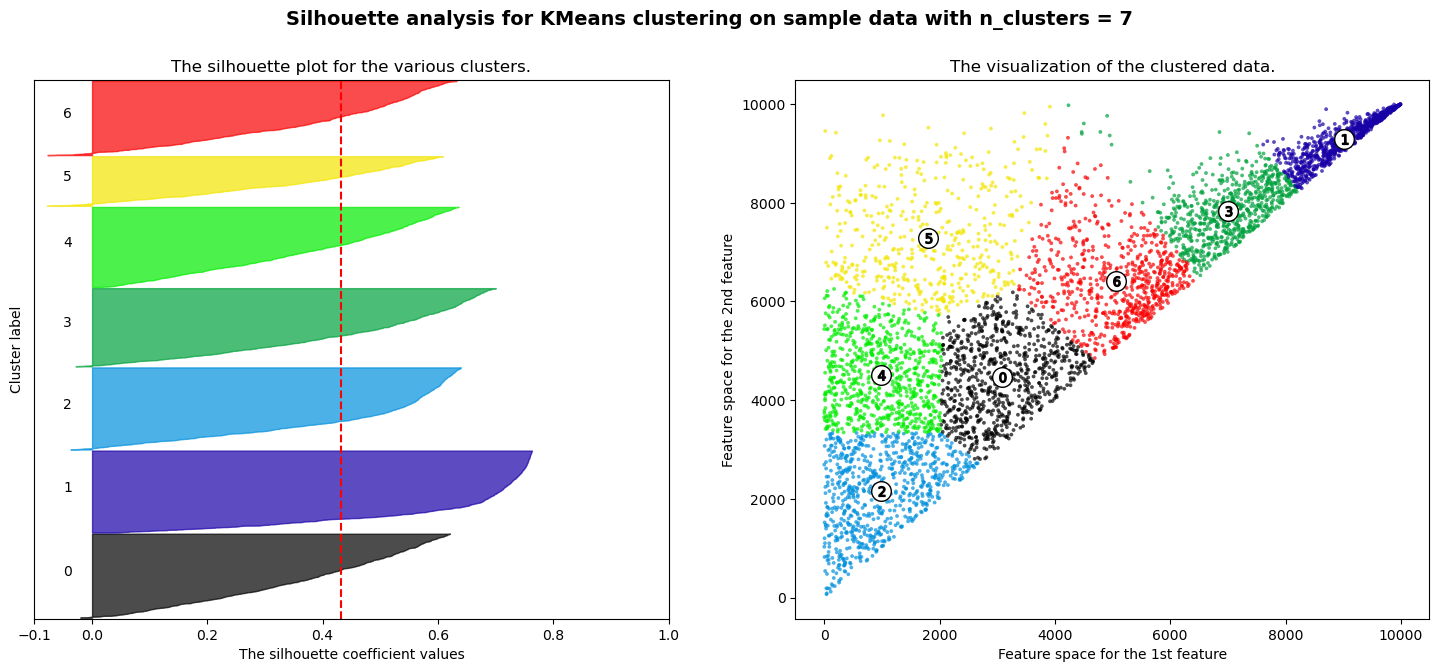

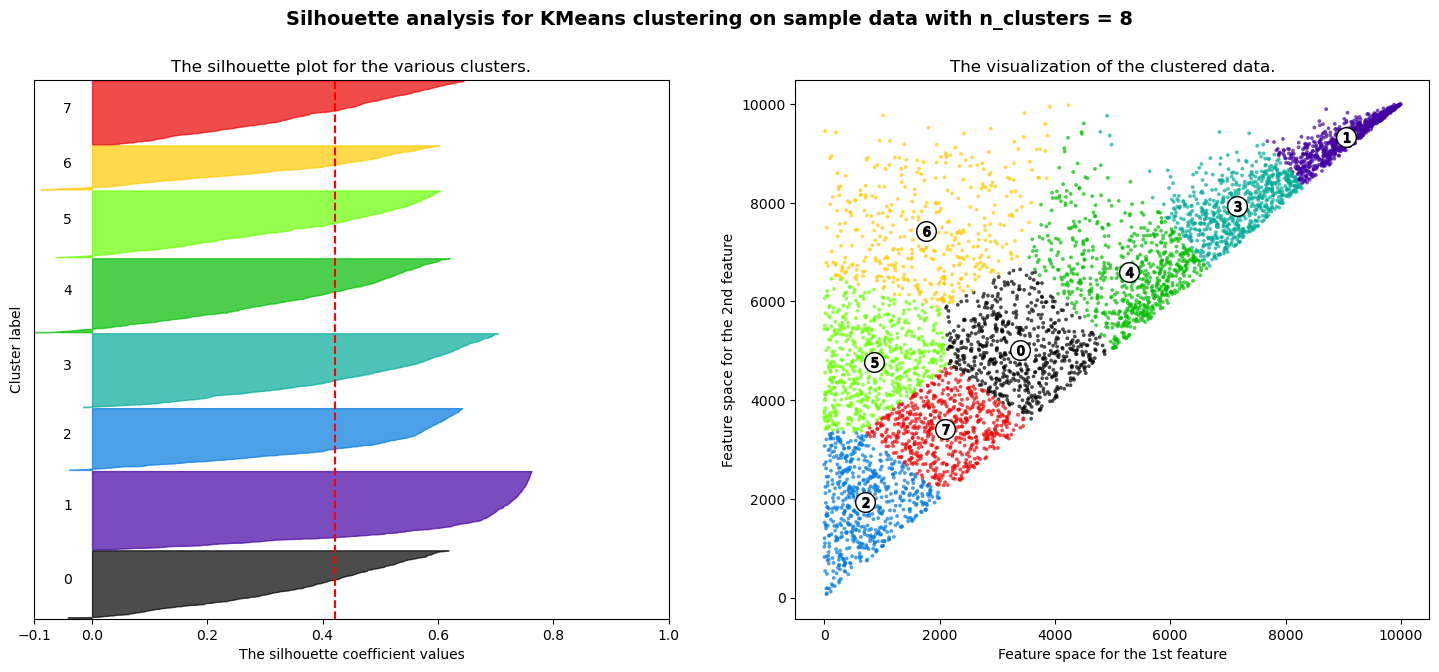

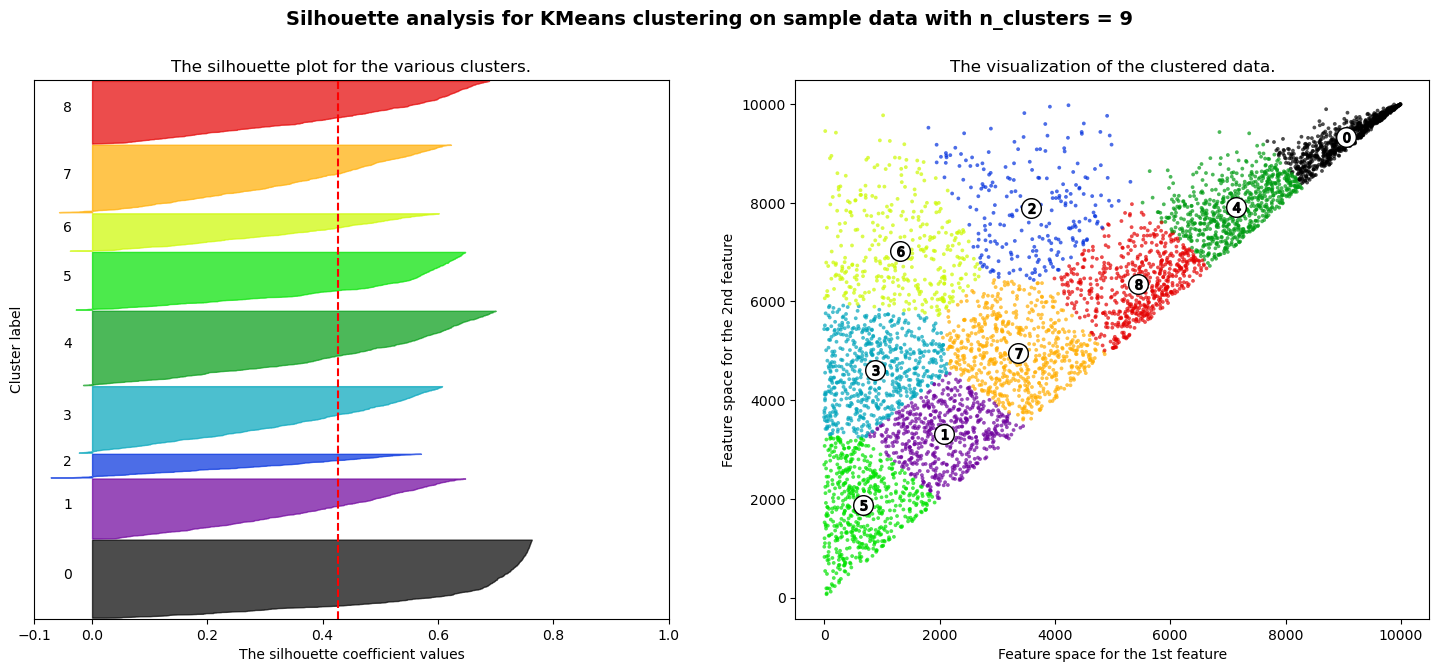

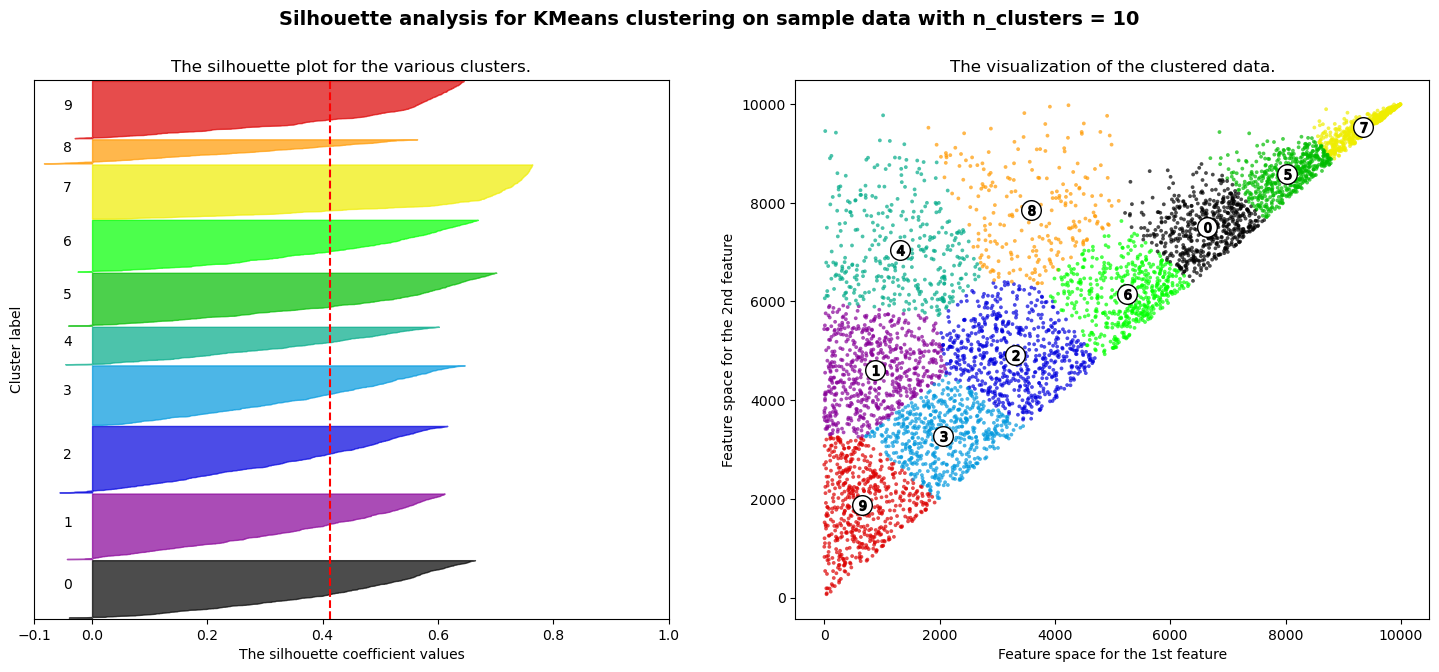

In [30]:
visualize_silhouette(10, agglo_clustering.children_)

11. Jot down recommendations or followup steps, detailing the reasons.

    *YOUR ANSWER HERE*
    Using Agglomerative Clustering creates more rectangular shapes in silhouette analysis, therefore using different cluster other than KMeans would give better outcome.  

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [161]:
new = pd.read_csv('../dat/new.csv.gz')

In [162]:
assert new.shape == (30091, 5)

In [163]:
new.head()

product_id   maxPrice   minPrice  Purchased?  Category
0     5866502   7.616667   7.616667           0       1.0
1     5870408   6.270000   6.270000           0       3.0
2     5900580  10.008000  10.008000           0       1.0
3     5918778   5.980000   5.980000           0       2.5
4     5848772  26.830000  26.830000           0       1.0

2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

        *YOUR ANSWER HERE*
The number of data points in the training set (past) is much smaller than the number of data points in the test set (new), as the training set has only 5000 data points while the test set has 30091 data points.

The feature set in the training set (past) and the feature set in the test set (new) are the same, as both sets have 5 features each.

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [136]:
intersecting_ids = np.intersect1d(new['product_id'].unique(), past['product_id'].unique())

In [138]:
# YOUR CODE HERE
intersecting_ids.shape

(0,)

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [164]:
# YOUR CODE HERE # ~.344

#total_purchases = new['Purchased?'].sum()
#total_data_points = new.shape[0]
#purchase_percentage = total_purchases / total_data_points
#purchase_percentage
new['Purchased?'].sum() / new.shape[0]

0.3442557575354757

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [165]:
features = ['product_id', 'maxPrice','minPrice','Purchased?','Category']

X_train = past[features]
y_train = X_train.pop('Purchased?')

y_test = new.pop('Purchased?')
X_test = new

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()


In [166]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [173]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

y_train_binary = np.where(y_train >= 0.5, 1, 0)
y_test_binary = np.where(y_test >= 0.5, 1, 0)

logistic_regression = LogisticRegression(solver='lbfgs')

logistic_regression.fit(X_train, y_train_binary)

y_pred = logistic_regression.predict(X_test)

accuracy = accuracy_score(y_test_binary, y_pred)
prec = precision_score(y_test_binary, y_pred)
rec = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
roc_auc = roc_auc_score(y_test_binary, y_pred)

print("Accuracy:", accuracy)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC AUC:", roc_auc)


Accuracy: 0.6557442424645242
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC: 0.5


/opt/homebrew/Caskroom/miniforge/base/envs/mle11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [168]:
#X_train.shape (30091, 3)
X_test.shape #(30091, 3)

(30091, 4)

In [169]:
# YOUR CODE HERE
X = np.vstack((X_train, X_test))
X.shape

(35091, 4)

In [174]:
assert X.shape == (35091, 4)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [175]:
# YOUR CODE HERE
y = np.hstack((y_train, y_test))

In [176]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [177]:
# YOUR CODE HERE

from sklearn.semi_supervised import LabelSpreading
from sklearn.neighbors import KNeighborsClassifier

label_spread = LabelSpreading(kernel='knn', alpha=0.01)

knn = KNeighborsClassifier(n_neighbors=5)

label_spread.fit(X, y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [182]:
semi_sup_preds = label_spread.predict(X_test)

In [183]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [184]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     19732
           1       0.74      0.64      0.68     10359

    accuracy                           0.80     30091
   macro avg       0.78      0.76      0.77     30091
weighted avg       0.79      0.80      0.79     30091



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [185]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79     19732
           1       0.00      0.00      0.00     10359

    accuracy                           0.66     30091
   macro avg       0.33      0.50      0.40     30091
weighted avg       0.43      0.66      0.52     30091



/opt/homebrew/Caskroom/miniforge/base/envs/mle11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mle11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mle11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

    *YOUR ANSWER HERE*

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)